# Timetable/ Scheduling problem

Problem Definition:
The Olympic games are almost here and in order to reduce the possible problems and avoid potential dangers this code tries to approach a solution to organzie the schedules during the games, taking into consideration the athletes, stadiums and timetables.

Constraints:

1. Events Duration 
Ensure that the event duration doesn't exceed the expected duration - soft.

2. Overlap Avoidance
Ensure no two events share the same venue at overlapping times. This constraint is crucial to prevent resource conflicts - hard.

3. Extra Time Between Events
Add buffer times to allow for setup, teardown, and potential delays. This buffer also helps with venue changes, allowing spectators and athletes to move between locations without overcrowding or time pressure - soft.

4. Daylight vs. Nighttime Events
Some events are better suited for daytime, while others are ideal for nighttime. Penalize schedules that assign events at inappropriate times - hard.

5. Athlete Rest and Recovery
Ensure athletes competing in multiple events have enough time to rest and recover. Penalize schedules that force athletes into back-to-back events without adequate breaks - soft.

6. Multi-Event Conflicts
Avoid conflicts for athletes competing in multiple events. Penalize schedules that require an athlete to be in two places at once or with inadequate spacing between events - hard.

In [1]:
from datetime import datetime, date, timedelta
from operator import attrgetter
from random import uniform, choice
from random import shuffle, choice, sample, random
from copy import copy
from random import randint
from datetime import datetime, timedelta

import itertools
import matplotlib.pyplot as plt
import bisect  # Add this import statement
import pandas as pd
import numpy as np
import random

In [2]:
# Create sample data 
# Define a set of venues with different capacities and locations
venue_data = {
    'venue_id': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'venue_name': ['Stadium A', 'Arena B', 'Field C', 'Hall D', 'Pool E', 'Court F', 'Rink G', 'Track H', 'Basket Field', 'Gym I', 'Pool J', 'Court K', 'Archery Field', 'Marina', 'Rink N'],
    'opening_time':[9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,],
    'closing_time':[22,22,22,22,22,22,22,22,22,22,22,22,22,22,22],
}


# Create a set of events with different durations and gender requirements
event_data = {
    'event_id': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'event_name': ['Track 100m', 'Tennis Singles', 'Soccer', 'Basketball', 'Swimming 100m Freestyle', 'Gymnastics', 'Tennis Doubles', 'Field Hockey', 
        'Figure Skating', 'High Jump',
        'Archery', 'Diving', 'Long Jump', 'Sailing', 'Triathlon'
    ],
    'venue_id': [8, 6, 3, 9, 5, 10, 6, 7, 15, 8, 13, 5, 8, 14, 3],  # Assigning events to venues
    'duration_hours': [1, 2, 3, 2, 1, 3, 2, 2, 1, 1, 2, 1, 1, 2, 2],
}

# Create a set of athletes with diverse attributes
athlete_data = {
    'athlete_id': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63],
    'athlete_name': ['Alice', 'Bob', 'Charlie', 'Diana', 'Eve', 'Frank', 'Grace', 'Henry', 'Isabel', 'Jack', 'Benfica', 'Sporting', 'Braga', 'Porto', 'Canada Team', 'USA Team', 'Art', 'Patrick', 'Sinner', 'Alcaraz', 'Anastasia', 'Vladimir', 'Shawn', 'Camila', 'Anna', 'Tom', 'Real Madrid', 'PSG', 'NY', 'NJ', 'Michael', 'Pierre', 'Carlos', 'Oscar', 'Simone', 'Sienna', 'Bears', 'Copenhagen Ice', 'Charles', 'Alexandra', 'Lando', 'Margarida', 'Nadal', 'Federer', 'Djokovic', 'Rublev', 'Fernando', 'Sainz', 'Yuki', 'Paula', 'Aryna', 'Coco', 'Sakkari', 'Daniel', 'George', 'Rafael', 'Novak', 'Aundrey', 'Rok', 'Rebecca', 'Kary', 'Nuno', 'Borges'],
    'event_ids': [[1], [3], [5], [7], [9], [11], [13], [1], [3], [5], [3], [3], [4],[4], [8], [8], [2,7], [2,7], [2,7], [2,7], [9], [9], [9],[9], [1], [1], [3], [3], [4], [4], [5], [5], [6], [6], [6], [6], [8], [8], [9], [9], [9], [9], [10,13], [10], [10,13], [10], [11], [11], [11], [10,13], [10,13], [14], [14], [14], [14], [15], [15], [15], [15], [12], [12], [12], [12]]  
}

# Convert athlete_data dictionary to a DataFrame
athletes = pd.DataFrame(athlete_data)
events = pd.DataFrame(event_data)
venues = pd.DataFrame(venue_data)

# Convert 'opening_time' and 'closing_time' columns to datetime objects
venues['opening_time'] = pd.to_datetime(venues['opening_time'], unit='h')
venues['closing_time'] = pd.to_datetime(venues['closing_time'], unit='h')

# Print the DataFrames
print("Venues:")
print(venues)
print("\nEvents:")
print(events)
print("\nAthletes:")
print(athletes)

Venues:
    venue_id     venue_name        opening_time        closing_time
0          1      Stadium A 1970-01-01 09:00:00 1970-01-01 22:00:00
1          2        Arena B 1970-01-01 09:00:00 1970-01-01 22:00:00
2          3        Field C 1970-01-01 09:00:00 1970-01-01 22:00:00
3          4         Hall D 1970-01-01 09:00:00 1970-01-01 22:00:00
4          5         Pool E 1970-01-01 09:00:00 1970-01-01 22:00:00
5          6        Court F 1970-01-01 09:00:00 1970-01-01 22:00:00
6          7         Rink G 1970-01-01 09:00:00 1970-01-01 22:00:00
7          8        Track H 1970-01-01 09:00:00 1970-01-01 22:00:00
8          9   Basket Field 1970-01-01 09:00:00 1970-01-01 22:00:00
9         10          Gym I 1970-01-01 09:00:00 1970-01-01 22:00:00
10        11         Pool J 1970-01-01 09:00:00 1970-01-01 22:00:00
11        12        Court K 1970-01-01 09:00:00 1970-01-01 22:00:00
12        13  Archery Field 1970-01-01 09:00:00 1970-01-01 22:00:00
13        14         Marina 1970-01-01 0

# Defining the constraints

In [3]:
def fitness(schedule, events, athletes):
    duration_penalty = 0
    overlap_penalty = 0
    buffer_penalty = 0
    daylight_nighttime_penalty = 0
    rest_recovery_penalty = 0
    multi_event_conflict_penalty = 0
    
    # Hard constraints penalties
    overlap_penalty_multiplier = 100
    multi_event_conflict_multiplier = 100
    daylight_nighttime_penalty_multiplier = 100
    
    # Soft constraints penalties
    duration_penalty_multiplier = 15
    buffer_penalty_multiplier = 10
    rest_recovery_penalty_multiplier = 30
    
    # Durantion exceded
    for event in schedule:
        event_id = event['event_id']
        start_time = event['start_time']
        end_time = event['end_time']
        event_info = events[events['event_id'] == event_id].iloc[0]
        duration_hours = event_info['duration_hours']
        event_duration = end_time - start_time
        if event_duration.total_seconds() // 3600 > duration_hours:
            duration_penalty += duration_penalty_multiplier 

    # Overlap avoidance
    for i in range(len(schedule)):
        event1 = schedule[i]
        venue1 = event1['venue_id']
        start1 = event1['start_time']
        end1 = event1['end_time']
        for j in range(i + 1, len(schedule)):
            event2 = schedule[j]
            if venue1 == event2['venue_id']:
                start2 = event2['start_time']
                end2 = event2['end_time']
                if start1 < end2 and start2 < end1:
                    overlap_penalty += overlap_penalty_multiplier

    # Extra time between events (buffer)
    buffer_time = timedelta(minutes=30)
    for i in range(len(schedule) - 1):
        event1 = schedule[i]
        for j in range(i + 1, len(schedule)):
            event2 = schedule[j]
            if event1['venue_id'] == event2['venue_id']:
                end_time1 = event1['end_time']
                start_time2 = event2['start_time']
                if end_time1 + buffer_time > start_time2:
                    buffer_penalty += buffer_penalty_multiplier

    # Daylight vs. nighttime appropriateness
    daylight_start = datetime.strptime("08:00", "%H:%M").time()
    daylight_end = datetime.strptime("19:00", "%H:%M").time()
    for event in schedule:
        event_time = event['start_time'].time()
        if event['event_id'] in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] and not (daylight_start <= event_time <= daylight_end):
            daylight_nighttime_penalty += daylight_nighttime_penalty_multiplier

    # Athlete rest and recovery
    for athlete in athletes.itertuples():
        athlete_events = [event for event in schedule if event['event_id'] in athlete.event_ids]
        athlete_events.sort(key=lambda x: x['start_time'])  # Sort by start time
        for i in range(1, len(athlete_events)):
            event1 = athlete_events[i - 1]
            event2 = athlete_events[i]
            event1_end_time = event1['end_time']
            if event1_end_time + timedelta(hours=1) > event2['start_time']:  # Minimum 1-hour rest period
                rest_recovery_penalty += rest_recovery_penalty_multiplier
    
    # Multi-event conflicts
    for athlete in athletes.itertuples():
        athlete_events = [event for event in schedule if event['event_id'] in athlete.event_ids]
        athlete_events.sort(key=lambda x: x['start_time'])
        for i in range(1, len(athlete_events)):
            event1 = athlete_events[i - 1]
            event2 = athlete_events[i]
            if event1['end_time'] > event2['start_time']:  # Conflict between events
                multi_event_conflict_penalty += multi_event_conflict_multiplier
    
    # Total penalty as fitness value (lower is better)
    total_penalty = (
        duration_penalty +
        overlap_penalty +
        buffer_penalty +
        daylight_nighttime_penalty +
        rest_recovery_penalty +
        multi_event_conflict_penalty
    )

    return total_penalty  

# Fitness Sharing

In [4]:
def calculate_similarity(individual1, individual2):
    similarity = 0
    for event1, event2 in zip(individual1.representation, individual2.representation):
        if event1['event_id'] == event2['event_id']:
            similarity += 1
    return similarity

def adjust_fitness(population, similarity_threshold):
    for ind1 in population:
        similarity_sum = 0
        for ind2 in population:
            similarity = calculate_similarity(ind1, ind2)
            if similarity < similarity_threshold:
                similarity_sum += 1 - (similarity / similarity_threshold)
        # Adjust fitness based on similarity
        ind1.fitness /= (1 + similarity_sum)

# Schedule

In [5]:
# Define the scheduling window
start_date = datetime(2024, 7, 26, 9)  # Starting date and time
end_date = datetime(2024, 8, 11, 22)  # Ending date and time

In [6]:
class Individual:
    def __init__(self, representation=None, events=None, athletes=None):
        self.events = events
        self.athletes = athletes
        self.representation = representation
        self.fitness = self.get_fitness() if representation else float('inf')
        self.length = len(representation) if representation else 0

    def get_fitness(self):
        return fitness(self.representation, self.events, self.athletes)

    def index(self, value):
        return self.representation.index(value)

    def __len__(self):
        return self.length

    def __getitem__(self, position):
        return self.representation[position]

    def __setitem__(self, position, value):
        self.representation[position] = value

    def __repr__(self):
        return f"Fitness: {self.fitness}"

class Population:
    def __init__(self, size, optim, events, athletes, venues, start_date, end_date):
        self.size = size
        self.optim = optim
        self.individuals = []
        self.events = events
        self.athletes = athletes
        self.venues = venues
        self.start_date = start_date
        self.end_date = end_date

        for _ in range(size):
            schedule = self.generate_initial_schedule()
            self.individuals.append(Individual(representation=schedule, events=self.events, athletes=self.athletes))

    def generate_initial_schedule(self):
        schedule = []
        for athlete in self.athletes.itertuples():
            for event_id in athlete.event_ids:
                event = self.events[self.events['event_id'] == event_id].iloc[0]
                start_time = self.generate_random_start_time(event)
                end_time = start_time + timedelta(hours=int(event['duration_hours']))
                schedule.append({
                    'event_id': event_id,
                    'start_time': start_time,
                    'end_time': end_time,
                    'athlete_id': athlete.athlete_id,
                    'venue_id': event['venue_id']
                })
        return schedule

    def generate_random_start_time(self, event):
        venue_id = event['venue_id']
        venue = self.venues[self.venues['venue_id'] == venue_id].iloc[0]
        opening_time = venue['opening_time'].time()
        closing_time = venue['closing_time'].time()
        
        # Calculate the number of days in the scheduling window
        days_range = (self.end_date - self.start_date).days
        
        # Randomly select a day within the scheduling window
        random_day_offset = randint(0, days_range)
        random_day = self.start_date + timedelta(days=random_day_offset)
        
        # Generate a random start time within the opening and closing times of the venue on the selected day
        time_range = datetime.combine(random_day, closing_time) - datetime.combine(random_day, opening_time)
        random_offset = timedelta(minutes=randint(0, int(time_range.total_seconds() / 60)))
        start_time = datetime.combine(random_day, opening_time) + random_offset
        
        return start_time

    def __len__(self):
        return len(self.individuals)

    def __getitem__(self, position):
        return self.individuals[position]

    def evolve(self, gens, xo_prob, mut_prob, select, xo, mutate, elitism, similarity_threshold):
        generation_fitness = []
        for i in range(gens):
            new_pop = []
            if elitism:
                elite = max(self.individuals, key=attrgetter('fitness')) if self.optim == "max" else min(self.individuals, key=attrgetter('fitness'))
                new_pop.append(elite)

            while len(new_pop) < self.size:
                parent1, parent2 = select(self), select(self)
                offspring1, offspring2 = parent1, parent2

                if random.random() < xo_prob:
                    offspring1, offspring2 = xo(parent1, parent2)

                if random.random() < mut_prob:
                    offspring1 = mutate(offspring1)

                if random.random() < mut_prob:
                    offspring2 = mutate(offspring2)
            
                # Append offspring to new population
                new_pop.append(offspring1)
                if len(new_pop) < self.size:
                    new_pop.append(offspring2)

            # Adjust fitness based on similarity
            adjust_fitness(new_pop, similarity_threshold)

            self.individuals = new_pop
            best_individual = max(self.individuals, key=attrgetter('fitness')) if self.optim == "max" else min(self.individuals, key=attrgetter('fitness'))
            generation_fitness.append(best_individual.fitness)

        return generation_fitness

# Olympic Selection

In [7]:
def tournament_sel(population, tour_size=3):
    tournament = [choice(population.individuals) for _ in range(tour_size)]
    if population.optim == "max":
        return max(tournament, key=attrgetter('fitness'))
    elif population.optim == "min":
        return min(tournament, key=attrgetter('fitness'))
    

def fitness_proportionate_sel(population):
    # Handle negative fitness values by shifting them
    min_fitness = min(ind.fitness for ind in population.individuals)
    offset = 0
    if min_fitness < 0:
        offset = -min_fitness
    
    # Calculate the total fitness with offset
    total_fitness = sum(ind.fitness + offset for ind in population.individuals)
    
    # Check for the edge case where the total fitness is zero
    if total_fitness == 0:
        # Randomly select an individual if all fitness values are zero
        return random.choice(population.individuals)
    
    pick = random.uniform(0, total_fitness)
    current = 0
    
    for ind in population.individuals:
        current += ind.fitness + offset
        if current >= pick:  # Using >= to ensure we always select an individual
            return ind
   

def rank_selection(population):
    # Rank individuals by fitness
    sorted_individuals = sorted(population.individuals, key=attrgetter('fitness'), reverse=(population.optim == "max"))
    
    # Create a list of ranks
    ranks = range(1, len(sorted_individuals) + 1)
    
    # Calculate total rank sum
    total_rank_sum = sum(ranks)
    
    # Calculate selection probabilities based on rank
    selection_probabilities = [rank / total_rank_sum for rank in ranks]
    
    # Select an individual based on the calculated probabilities
    selected_index = random.choices(range(len(sorted_individuals)), weights=selection_probabilities, k=1)[0]
    
    return sorted_individuals[selected_index]

# Cross Over

In [8]:
def single_point_xo(parent1, parent2):
    xo_point = randint(1, len(parent1.representation) - 1)
    
    # Combine the representations of both parents at the crossover point
    offspring1_representation = parent1.representation[:xo_point] + parent2.representation[xo_point:]
    offspring2_representation = parent2.representation[:xo_point] + parent1.representation[xo_point:]
    
    # Create new Individuals with the combined representations
    offspring1 = Individual(representation=offspring1_representation, events=parent1.events, athletes=parent1.athletes)
    offspring2 = Individual(representation=offspring2_representation, events=parent2.events, athletes=parent2.athletes)
    
    return offspring1, offspring2


def uniform_xo(parent1, parent2):

    # Initialize offspring representations with the same length as parents
    offspring1_representation = [None] * len(parent1.representation)
    offspring2_representation = [None] * len(parent2.representation)

    # Iterate over each gene position
    for i in range(len(parent1.representation)):
        if random.random() < 0.5:  # Randomly select gene from parent1
            offspring1_representation[i] = parent1.representation[i]
            offspring2_representation[i] = parent2.representation[i]
        else:  # Randomly select gene from parent2
            offspring1_representation[i] = parent2.representation[i]
            offspring2_representation[i] = parent1.representation[i]

    # Create new Individuals with the combined representations
    offspring1 = Individual(representation=offspring1_representation, events=parent1.events, athletes=parent1.athletes)
    offspring2 = Individual(representation=offspring2_representation, events=parent2.events, athletes=parent2.athletes)

    return offspring1, offspring2

# Mutation

In [9]:
def swap_mutation(individual):
    mut_indexes = random.sample(range(len(individual.representation)), 2)
    
    event1 = individual.representation[mut_indexes[0]]
    event2 = individual.representation[mut_indexes[1]]
    
    # Swap the events
    individual.representation[mut_indexes[0]], individual.representation[mut_indexes[1]] = event2, event1
    
    # Recalculate fitness after mutation
    individual.fitness = individual.get_fitness()

    return individual


def inversion_mutation(individual):
    ind_size = len(individual.representation)
    mut_points = sorted(random.sample(range(ind_size), 2))
    start, end = mut_points[0], mut_points[1]
    
    # Reverse the segment including the start and end times
    individual.representation[start:end] = reversed(individual.representation[start:end])
    
    # Recalculate fitness after mutation
    individual.fitness = individual.get_fitness()

    return individual

# Mutation Search:

In [10]:
def mutation_search(population, num_generations, crossover_probability, mutation_probability, events, athletes, venues, start_date, end_date):
    fitness_evolution_mutation = {'swap': [], 'inversion': []}

    mutation_methods = {'swap': swap_mutation, 'inversion': inversion_mutation}
    crossover_func = uniform_xo  
    #crossover_func = single_point_xo

    for mutation_name, mutation_func in mutation_methods.items():
        all_fitness_scores = []

        for i in range(7):
            fitness_scores = []

            pop = Population(
                size=population,
                optim="min",
                events=events,
                athletes=athletes,
                venues=venues,
                start_date=start_date,
                end_date=end_date
            )

            # Execute the Evolutionary Algorithm
            generation_fitness = pop.evolve(
                gens=num_generations,
                xo_prob=crossover_probability,
                mut_prob=mutation_probability,
                select=tournament_sel,
                #select=fitness_proportionate_sel,
                #select=rank_selection,
                xo=crossover_func,
                mutate=mutation_func,
                elitism=True,
                similarity_threshold=0.1
            )

            # Append the generation fitness to all fitness scores
            fitness_scores.extend(generation_fitness)

            # Append the fitness scores to the list of all fitness scores for this combination
            all_fitness_scores.append(fitness_scores)

        # Calculate the median fitness for this combination
        median_fitness = np.median(all_fitness_scores, axis=0)  # axis=0 to get median across runs for each generation
        
        # Append the median fitness to the respective mutation method dictionary
        fitness_evolution_mutation[mutation_name].append(median_fitness)

    return fitness_evolution_mutation

# Cross-Over Search:

In [11]:
def crossover_search(population, num_generations, crossover_probability, mutation_probability, events, athletes, venues, start_date, end_date):
    fitness_evolution_crossover = {'single_point': [], 'uniform': []}

    crossover_methods = {'single_point': single_point_xo, 'uniform': uniform_xo}
    mutation_func = swap_mutation # mutation function with lower fitness results (Based on the Graphs)

    for crossover_name, crossover_func in crossover_methods.items():
        all_fitness_scores = []
        for _ in range(7): 
            fitness_scores = []

            pop = Population(
                size=population,
                optim="min",
                events=events,
                athletes=athletes,
                venues=venues,
                start_date=start_date,
                end_date=end_date
            )

            # Execute the Evolutionary Algorithm 
            generation_fitness = pop.evolve(
                gens=num_generations,
                xo_prob=crossover_probability,
                mut_prob=mutation_probability,
                select=tournament_sel,
                xo=crossover_func,
                mutate=mutation_func,
                elitism=True,
                similarity_threshold=0.1  
            )

            # Append the generation fitness to all fitness scores
            fitness_scores.extend(generation_fitness)

            # Append the fitness scores to the list of all fitness scores for this combination
            all_fitness_scores.append(fitness_scores)

        # Calculate the median fitness for this combination
        median_fitness = np.median(all_fitness_scores, axis=0)  # axis=0 to get median across runs for each generation
        
        # Append the median fitness to the respective crossover method dictionary
        fitness_evolution_crossover[crossover_name].append(median_fitness)

    return fitness_evolution_crossover

# Plot Fitness Evolution

In [12]:
def plot_fitness_evolution(fitness_evolution_data, title, ylabel):
    fig, ax = plt.subplots(figsize=(10, 6))
    for method, fitness_evolution in fitness_evolution_data.items():
        fitness_array = np.array(fitness_evolution)
        median_fitness_evolution = np.median(fitness_array, axis=0)
        ax.plot(median_fitness_evolution, label=method)
    
    ax.set_xlabel('Generations')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Grid Search:
#### Hyperparameters to be tuned: 
    -population size
    -number of generations
    -crossover probability
    -mutation probability

In [13]:
def grid_search(param_grid, events, athletes, venues, start_date, end_date):
    best_fitness = float('inf')
    best_params = None
    best_population = None
    best_individual = None
    results = []

    for pop_size in param_grid['population_size']:
        for num_gens in param_grid['num_generations']:
            for xo_prob in param_grid['crossover_probability']:
                for mut_prob in param_grid['mutation_probability']:
                    for elitism in param_grid['elitism']:
                        fitness_scores = []

                        for _ in range(7): 
                            population = Population(
                                size=pop_size,
                                optim="min",
                                events=events,
                                athletes=athletes,
                                venues=venues,
                                start_date=start_date,
                                end_date=end_date
                            )

                            # Execute the Evolutionary Algorithm with fitness capture
                            population.evolve(
                                gens=num_gens,
                                xo_prob=xo_prob,
                                mut_prob=mut_prob,
                                select=tournament_sel,
                                xo=uniform_xo,  
                                mutate=swap_mutation,  
                                elitism=elitism,
                                similarity_threshold=0.1  
                            )

                            best_run_individual = min(population.individuals, key=attrgetter('fitness'))
                            fitness_scores.append(best_run_individual.fitness)

                            # Update the best individual and its population if this run's best individual is better
                            if best_run_individual.fitness < best_fitness:
                                best_fitness = best_run_individual.fitness
                                best_individual = best_run_individual
                                best_population = population

                        median_fitness = np.median(fitness_scores)

                        # Record the results
                        result = {
                            'population_size': pop_size,
                            'num_generations': num_gens,
                            'crossover_probability': xo_prob,
                            'mutation_probability': mut_prob,
                            'elitism': elitism,
                            'median_fitness': median_fitness
                        }
                        results.append(result)

                        # Update the best parameters based on the median fitness
                        if median_fitness < best_fitness:
                            best_params = result

    return best_params, results, best_population, best_individual


# Let the Games Begin

In [14]:
# Perform mutation search with uniform_xo and tournament_sel
fitness_evolution_mutation= mutation_search(200,100, 0.8, 0.1, events, athletes, venues, start_date, end_date)

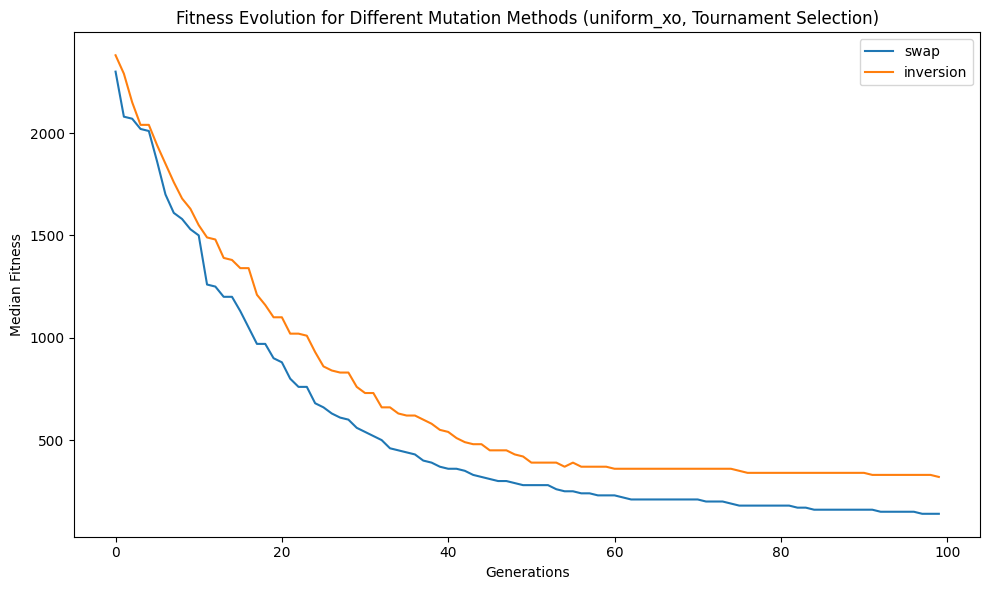

In [15]:
# Plot fitness evolution for mutation methods
plot_fitness_evolution(fitness_evolution_mutation, 'Fitness Evolution for Different Mutation Methods (uniform_xo, Tournament Selection)', 'Median Fitness')

In [17]:
# Perform mutation search with single_point_xo and tournament_sel
fitness_evolution_mutation= mutation_search(200,100, 0.8, 0.1, events, athletes, venues, start_date, end_date)

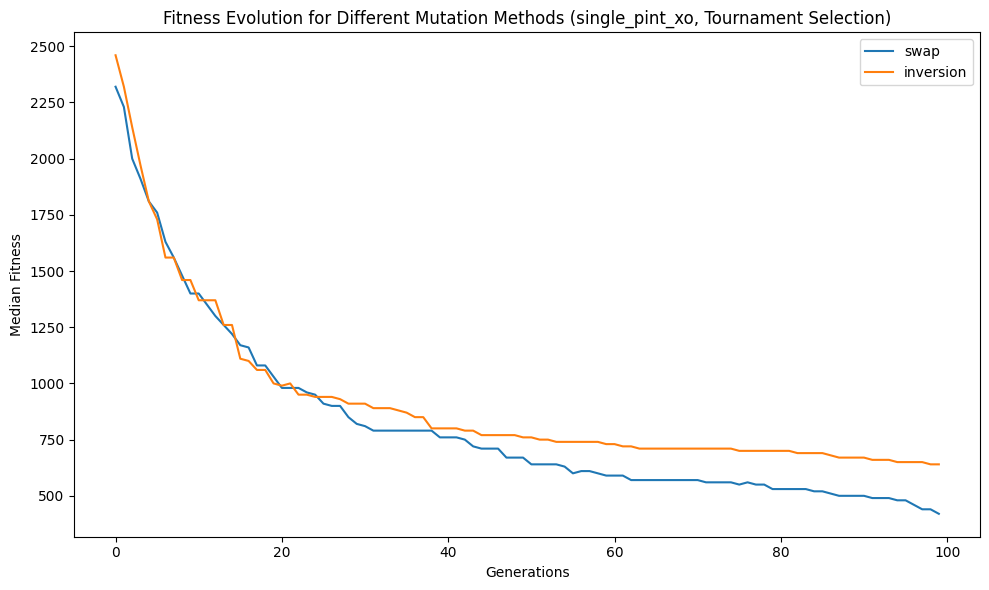

In [18]:
# Plot fitness evolution for mutation methods
plot_fitness_evolution(fitness_evolution_mutation, 'Fitness Evolution for Different Mutation Methods (single_pint_xo, Tournament Selection)', 'Median Fitness')

In [20]:
# Perform mutation search with uniform_xo and fitness_proporcionate_sel
fitness_evolution_mutation= mutation_search(200,100, 0.8, 0.1, events, athletes, venues, start_date, end_date)

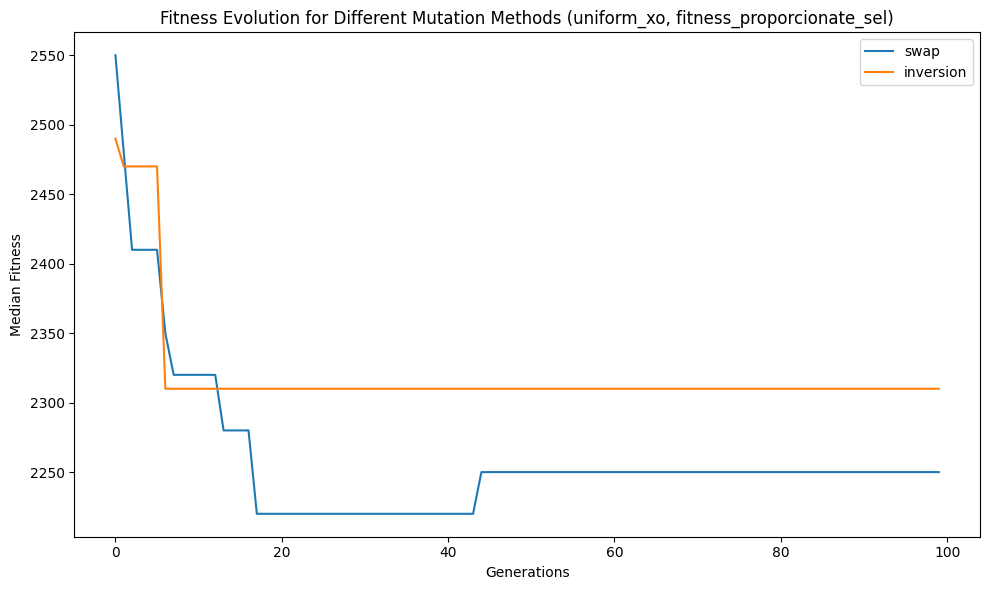

In [21]:
# Plot fitness evolution for mutation methods
plot_fitness_evolution(fitness_evolution_mutation, 'Fitness Evolution for Different Mutation Methods (uniform_xo, fitness_proporcionate_sel)', 'Median Fitness')

In [23]:
# Perform mutation search with single_point_xo and fitness_proporcionate_sel
fitness_evolution_mutation= mutation_search(200,100, 0.8, 0.1, events, athletes, venues, start_date, end_date)

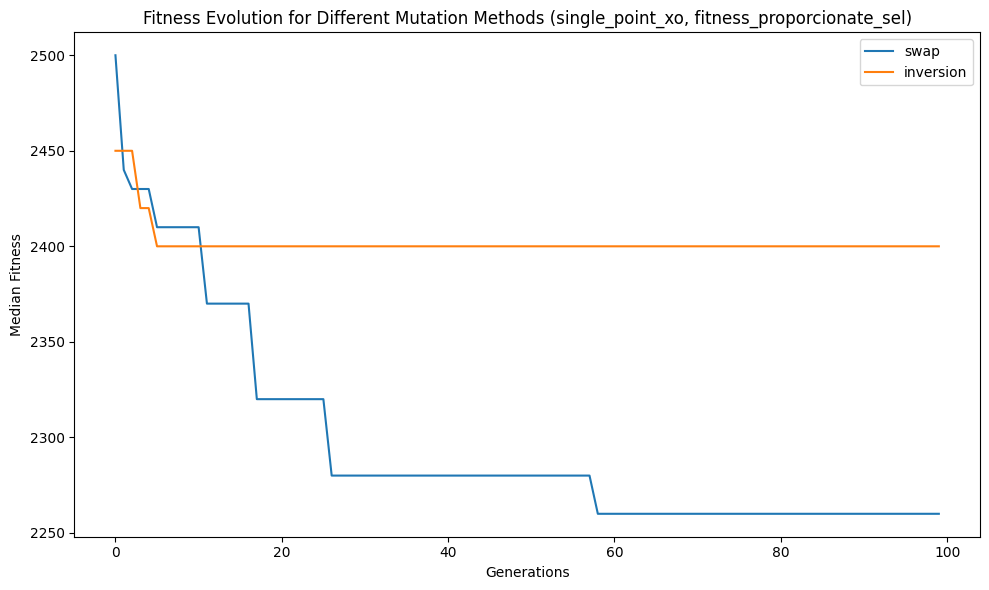

In [24]:
# Plot fitness evolution for mutation methods
plot_fitness_evolution(fitness_evolution_mutation, 'Fitness Evolution for Different Mutation Methods (single_point_xo, fitness_proporcionate_sel)', 'Median Fitness')

In [26]:
# Perform mutation search with uniform_xo and rank_sel
fitness_evolution_mutation= mutation_search(200,100, 0.8, 0.1, events, athletes, venues, start_date, end_date)

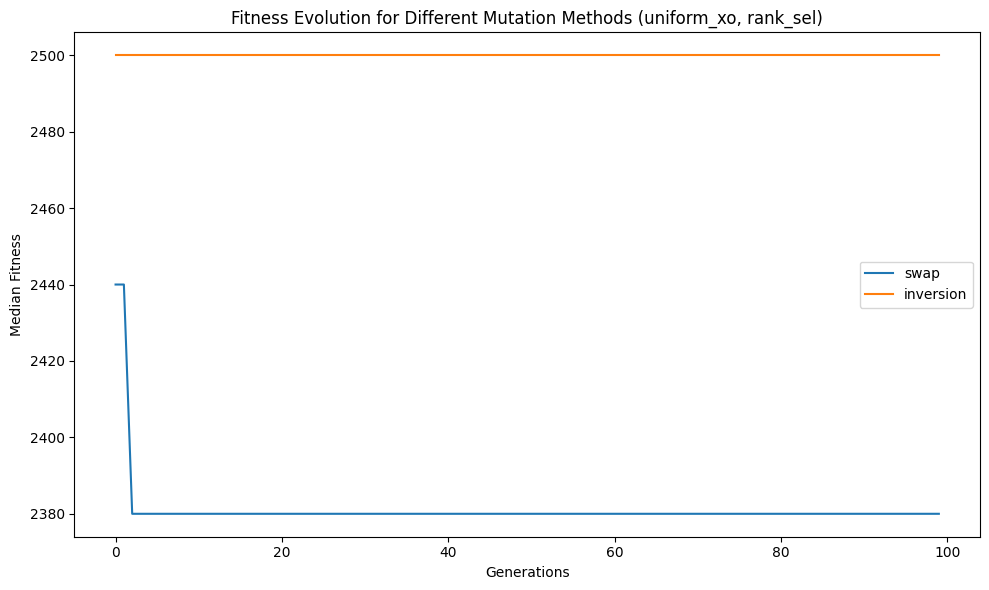

In [27]:
# Plot fitness evolution for mutation methods
plot_fitness_evolution(fitness_evolution_mutation, 'Fitness Evolution for Different Mutation Methods (uniform_xo, rank_sel)', 'Median Fitness')

In [29]:
# Perform mutation search with single_point_xo and rank_sel
fitness_evolution_mutation= mutation_search(200,100, 0.8, 0.1, events, athletes, venues, start_date, end_date)

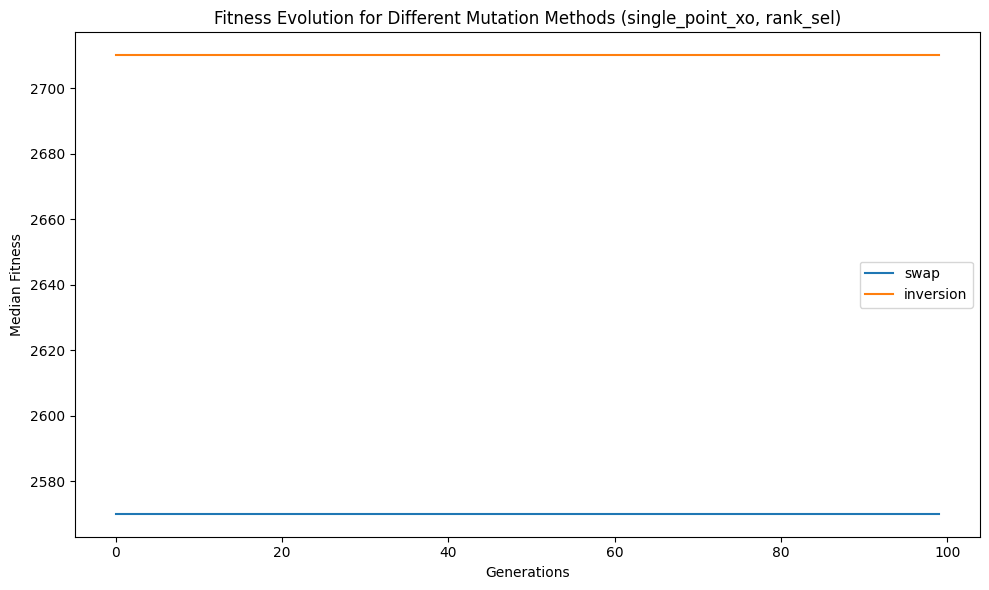

In [30]:
# Plot fitness evolution for mutation methods
plot_fitness_evolution(fitness_evolution_mutation, 'Fitness Evolution for Different Mutation Methods (single_point_xo, rank_sel)', 'Median Fitness')

In [31]:
# Perform crosssover search
fitness_evolution_crossover = crossover_search(200, 100, 0.8, 0.1, events, athletes, venues, start_date, end_date)

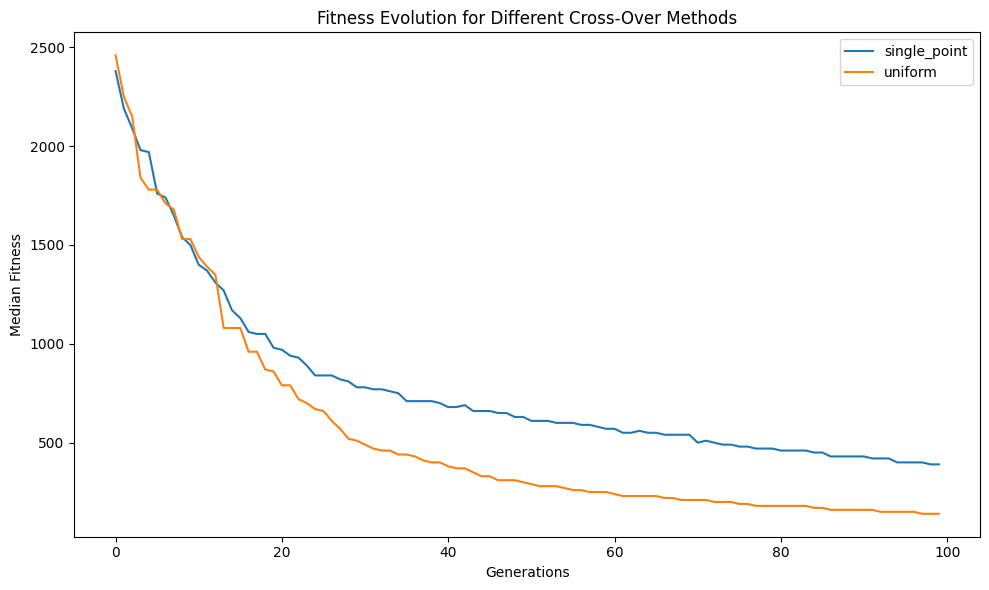

In [32]:
# Plot fitness evolution for Cross-Over methods (swap_mutation)
plot_fitness_evolution(fitness_evolution_crossover, 'Fitness Evolution for Different Cross-Over Methods', 'Median Fitness')

In [14]:
# Define the parameter grid
param_grid = {
    'population_size': [100, 200],  
    'num_generations': [50, 100], 
    'crossover_probability': [0.6, 0.8],  
    'mutation_probability': [0.05, 0.1],
    'elitism': [True, False]
}

# Perform the grid search
best_params, grid_search_results, best_population, best_individual = grid_search(param_grid, events, athletes, venues, start_date, end_date)

print("Best Individual:", best_individual)
print("Best Individual Fitness:", best_individual.fitness)
print("Best hyperparameters:", best_params)
print("Best schedule:", best_individual.representation)

best_schedule_df = pd.DataFrame(best_individual.representation)
best_schedule_df.to_excel("best_schedule.xlsx", index=False)
print("Best schedule saved to Excel file: best_schedule.xlsx")

Best Individual: Fitness: 70.0
Best Individual Fitness: 70.0
Best hyperparameters: None
Best schedule: [{'event_id': 1, 'start_time': datetime.datetime(2024, 7, 26, 15, 29), 'end_time': datetime.datetime(2024, 7, 26, 16, 29), 'athlete_id': 1, 'venue_id': 8}, {'event_id': 3, 'start_time': datetime.datetime(2024, 7, 26, 14, 58), 'end_time': datetime.datetime(2024, 7, 26, 17, 58), 'athlete_id': 2, 'venue_id': 3}, {'event_id': 5, 'start_time': datetime.datetime(2024, 8, 1, 17, 58), 'end_time': datetime.datetime(2024, 8, 1, 18, 58), 'athlete_id': 3, 'venue_id': 5}, {'event_id': 7, 'start_time': datetime.datetime(2024, 7, 29, 12, 12), 'end_time': datetime.datetime(2024, 7, 29, 14, 12), 'athlete_id': 4, 'venue_id': 6}, {'event_id': 9, 'start_time': datetime.datetime(2024, 7, 28, 12, 38), 'end_time': datetime.datetime(2024, 7, 28, 13, 38), 'athlete_id': 5, 'venue_id': 15}, {'event_id': 11, 'start_time': datetime.datetime(2024, 7, 26, 14, 34), 'end_time': datetime.datetime(2024, 7, 26, 16, 34),

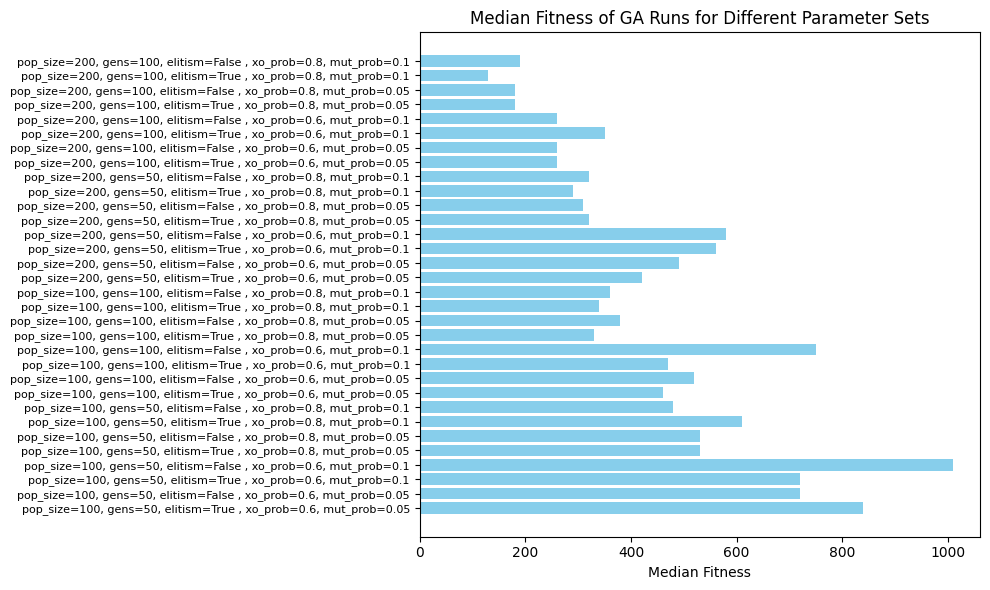

In [15]:
def plot_grid_search_results(results):
    # Plot the median fitness for each parameter set
    fig, ax = plt.subplots(figsize=(10, 6))
    parameter_sets = [f"pop_size={res['population_size']}, gens={res['num_generations']}, elitism={res['elitism']} , xo_prob={res['crossover_probability']}, mut_prob={res['mutation_probability']}" for res in results]
    median_fitnesses = [res['median_fitness'] for res in results]

    ax.barh(parameter_sets, median_fitnesses, color='skyblue')
    ax.set_xlabel('Median Fitness')
    ax.set_title('Median Fitness of GA Runs for Different Parameter Sets')
    ax.tick_params(axis='y', which='major', labelsize=8)  
    plt.tight_layout()
    plt.show()

plot_grid_search_results(grid_search_results)

### Checking violations on the final schedule

In [16]:
# Load the data from the Excel file
file_path = r'C:\Users\mafal\Desktop\CIFO_Project\best_schedule.xlsx'
schedule_df = pd.read_excel(file_path, sheet_name='Sheet1')

events_df = pd.DataFrame(event_data)

# Create the athletes dataframe
athlete_event_mapping = schedule_df.groupby('athlete_id')['event_id'].apply(list).reset_index()
athlete_event_mapping.columns = ['athlete_id', 'event_ids']
athletes_df = pd.DataFrame(athlete_event_mapping)

# Initialize penalties
overlap_penalty = 0
multi_event_conflict_penalty = 0
daylight_nighttime_penalty = 0
duration_penalty = 0
buffer_penalty = 0
rest_recovery_penalty = 0

# Hard constraints penalties
overlap_penalty_multiplier = 100
multi_event_conflict_multiplier = 100
daylight_nighttime_penalty_multiplier = 100

# Soft constraints penalties
duration_penalty_multiplier = 15
buffer_penalty_multiplier = 10
rest_recovery_penalty_multiplier = 30

# Durantion exceeded
for index, event in schedule_df.iterrows():
    event_id = event['event_id']
    start_time = event['start_time']
    end_time = event['end_time']
    event_info = events_df[events_df['event_id'] == event_id].iloc[0]
    duration_hours = event_info['duration_hours']
    event_duration = (end_time - start_time).total_seconds() // 3600
    if event_duration > duration_hours:
        duration_penalty += duration_penalty_multiplier

# Overlap avoidance
for i in range(len(schedule_df)):
    event1 = schedule_df.iloc[i]
    venue1 = event1['venue_id']
    start1 = event1['start_time']
    end1 = event1['end_time']
    for j in range(i + 1, len(schedule_df)):
        event2 = schedule_df.iloc[j]
        if venue1 == event2['venue_id']:
            start2 = event2['start_time']
            end2 = event2['end_time']
            if start1 < end2 and start2 < end1:
                overlap_penalty += overlap_penalty_multiplier

# Extra time between events (buffer)
buffer_time = timedelta(minutes=30)
for i in range(len(schedule_df) - 1):
    event1 = schedule_df.iloc[i]
    for j in range(i + 1, len(schedule_df)):
        event2 = schedule_df.iloc[j]
        if event1['venue_id'] == event2['venue_id']:
            end_time1 = event1['end_time']
            start_time2 = event2['start_time']
            if end_time1 + buffer_time > start_time2:
                buffer_penalty += buffer_penalty_multiplier

# Daylight vs. nighttime appropriateness
daylight_start = datetime.strptime("08:00", "%H:%M").time()
daylight_end = datetime.strptime("19:00", "%H:%M").time()
for index, event in schedule_df.iterrows():
    event_time = event['start_time'].time()
    if event['event_id'] in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] and not (daylight_start <= event_time <= daylight_end):
        daylight_nighttime_penalty += daylight_nighttime_penalty_multiplier

# Athlete rest and recovery
for index, athlete in athletes_df.iterrows():
    athlete_events = schedule_df[schedule_df['athlete_id'] == athlete['athlete_id']]
    athlete_events = athlete_events.sort_values(by='start_time')
    for i in range(1, len(athlete_events)):
        event1 = athlete_events.iloc[i - 1]
        event2 = athlete_events.iloc[i]
        event1_end_time = event1['end_time']
        if event1_end_time + timedelta(hours=1) > event2['start_time']:  # Minimum 1-hour rest period
            rest_recovery_penalty += rest_recovery_penalty_multiplier

# Multi-event conflicts
for index, athlete in athletes_df.iterrows():
    athlete_events = schedule_df[schedule_df['athlete_id'] == athlete['athlete_id']]
    athlete_events = athlete_events.sort_values(by='start_time')
    for i in range(1, len(athlete_events)):
        event1 = athlete_events.iloc[i - 1]
        event2 = athlete_events.iloc[i]
        if event1['end_time'] > event2['start_time']:  # Conflict between events
            multi_event_conflict_penalty += multi_event_conflict_multiplier

# Total penalty as fitness value (lower is better)
total_penalty = (
    duration_penalty +
    overlap_penalty +
    buffer_penalty +
    daylight_nighttime_penalty +
    rest_recovery_penalty +
    multi_event_conflict_penalty
)

print("Total Penalty:", total_penalty)
print("Duration Penalty:", duration_penalty)
print("Overlap Penalty:", overlap_penalty)
print("Buffer Penalty:", buffer_penalty)
print("Daylight Nighttime Penalty:", daylight_nighttime_penalty)
print("Rest Recovery Penalty:", rest_recovery_penalty)
print("Multi Event Conflict Penalty:", multi_event_conflict_penalty)

Total Penalty: 70
Duration Penalty: 0
Overlap Penalty: 0
Buffer Penalty: 70
Daylight Nighttime Penalty: 0
Rest Recovery Penalty: 0
Multi Event Conflict Penalty: 0
